## Variational AutoEncoder

### <차원의 저주>

차원이 증가하면 그것을 표현하기 위한 데이터의 수가 기하급수적으로 증가한다.

(일정 차원이 넘으면 분류기의 성능은 점점 떨어져 0으로 수렴함)

AE는 입력값보다 작은 차원을 갖는 hidden layer를 이용해 데이터 속에 숨어있는 변수를 발굴할 수 있게 해준다.

흔히 사용되는 PCA는 선형적인 한계가 있다. 하지만 AE는 뉴런이 갖고 있는 non-linear 및 constraints로 인해 훨씬 뛰어난 차원 축소 능력을 가지고 있다.


### <VAE와 AE의 차이>

VAE는 AE와 비슷하지만 약간 다른점이 존재한다. z가 training data와 특별이 관련이 없이 단순히 계산 중간에 나오는 한 값일 뿐이라면 VAE에서의 latent variable인 z는 continouous한 분포를 갖는 random variable이라는 점이 중요한 차이다. 이 latent variable z의 분포는 training 과정에서의 data로부터 학습된다.
(즉, VAE는 z를 좀 더 다루기 쉬운 우리가 잘 아는 분포(가우시안)의 형태를 띄게 만들어 지는 것

결론적으로, AE와 다른 점은 z 하나하나를 "모으고", "흔들어서", z 공간을 더 촘촘히 채워줘서 더 유용한 z 공간을 만든다는 것

http://blog.naver.com/PostView.nhn?blogId=laonple&logNo=220880813236&parentCategoryNo=&categoryNo=18&viewDate=&isShowPopularPosts=true&from=search

### < PCA vs VAE vs GAN >

https://spark-in.me/post/playing-with-vae-umap-pca

### <VAE 소스 출처>

http://nbviewer.jupyter.org/github/rickiepark/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb

In [3]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np


## 1. 사전 변경값 확인

In [144]:
# 구분 최초 설정 필요

df = 'main'
target_temp_df = 'Y'  # 정상:부실의 데이터 비율을 맞추기 위한 데이터셋을 사용할 건지 여부 (데이터스케일링 쥬피터 결과 기준)

# main/all/core 3가지로 설정 




# core설정시 확인해야 함
# R을 통해 확인한 stepwise 유의 변수 리스트
core_factors = ['DR00000136','6000201001O0','6000903016D1','FNMKFN02','6000901002D1','S41000210FD1',
'6000207003O0','DR00000052','6000906001D6','DR00000156','6000901001D3','DR00000082',
'S41000210FD2','6000902001D2','6000908001D3','6000904001D3','6000908001D2','S41B0D1009O0',
'6000901002D3','6000903001D2','6000403001O0','CO10100170O0','DR00000113','6000908001D7']

#  키별로 비율 배분이 잘 됐는지 확인
if df == 'all':
    max_idx = 707
else:
    max_idx = 124
    

## 2. 데이터셋 셋팅

In [145]:
import pickle # 파이썬 객체저장을 위한 모듈

# 파이썬 객체 읽어오기

if target_temp_df != 'Y':
    if df == 'all':
        with open('./pickles/dataset_all.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            train_set = pickle.load(file)
            test_set = pickle.load(file)
    else:
        with open('./pickles/dataset_main.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            train_set = pickle.load(file)
            test_set = pickle.load(file)
else:
# 정상:부실의 데이터 비율 조정 기준
    if df == 'all':
        with open('./pickles/data6vs4_all.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            temp_train_set = pickle.load(file)
            temp_test_set = pickle.load(file)
            af_cols = pickle.load(file)
    else:
        with open('./pickles/data6vs4_main.p', 'rb') as file:    # hello.txt 파일을 바이너리 읽기 모드(rb)로 열기
            temp_train_set = pickle.load(file)
            temp_test_set = pickle.load(file)
            af_cols = pickle.load(file)
            
# 필요없는 열 삭제
train_set = temp_train_set.drop(['index', 0, max_idx-1,max_idx],axis=1)  # 열삭제
test_set = temp_test_set.drop(['index', 0, max_idx-1,max_idx],axis=1)  # 열삭제


# 항목명 (열명) 셋팅
factor_cols = list(af_cols[1:-2])
train_set.columns = factor_cols
test_set.columns = factor_cols


In [146]:
# core인 경우 main에서 핵심 변수만 추림

if df == 'core':
    final_factors = ['key', 'industry', 'label']
    final_factors = final_factors + core_factors
    train_set = train_set[final_factors]
    test_set = test_set[final_factors]
else:
    pass

In [147]:
df, train_set.shape, test_set.shape

('main', (755, 122), (333, 122))

### 데이터 분리 및 타입변경

In [148]:
# 데이터 분리
cols = train_set.columns.values
train_info = train_set[cols[0:3]]
X_train = train_set[cols[3:]]
Y_train = train_set['label']
train_len = X_train.shape[0]

cols = test_set.columns.values
test_info = test_set[cols[0:3]]
X_test = test_set[cols[3:]]
Y_test = test_set['label']
test_len = X_test.shape[0]

In [149]:
X_train.shape, Y_train.shape

((755, 119), (755,))

In [150]:
X_train = np.array(X_train)
X_test = np.array(X_test)

### MIN MAX 스케일 조정
스케일링 하는 이유 : 데이터가 0~1이 아닐 경우 loss가 마이너스로 계산됨. 학습이 정상적이지 않을 수 있음.

다른 딥러닝 모델에서도 이미지 학습시 /255 처리하는 이유

In [151]:
# 데이터 스케일 조정 (MinMax)
# 재작업시 위에 실행 후 처리하기

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [173]:
X_train.shape

(755, 119)

In [152]:
X_train[0].reshape(1, X_train.shape[1], 1).shape

(1, 119, 1)

## 3. VAE 모델링

다음 코드는 이미지를 잠재 공간 상의 확률 분포 파라미터로 매핑하는 인코더 네트워크입니다. 입력 이미지 x를 두 벡터 z_mean과 z_log_var로 매핑하는 간단한 컨브넷입니다.


<오류케이스>


- 2차원 행렬 데이터의 경우, slide 사이즈 (1, ?) 형태가 되어야 함
    해당오류 : InvalidArgumentError: Incompatible shapes:

- InvalidArgumentError: Incompatible shapes:
    매칭되는 train과 test의 데이터 shape가 맞지 않거나 cpu 메모리가 너무 많이 소모되는 문제


<데이터shape>

mmist 한 row의 데이터 -> (28,28,1)

2차원데이터 한 row의 데이터 -> (1, 10, 1) # 10 factor 기준


In [213]:
m = X_train.shape[1] # 가로 열, 주의! 설명항목 제외
n = X_train.shape[0] # 세로 행 

# latent vector  z 의 차원   32
if m >= 300:
    latent_dim = 32
    filter_size = 32   # Conv2D에서 2개 적용되므로 
    MaxPool_size  = 4
if m >= 100:
    latent_dim = 32
    filter_size = 16   # Conv2D에서 2개 적용되므로 
    MaxPool_size  = 4
elif m >= 50:
    latent_dim = 16
    filter_size = 4    
    MaxPool_size = 4
else:
    latent_dim = 10   # 최소 10개 이상은 지정되어야 함. CNN 필터 사이즈 스캔 오류 가능
    filter_size = 2
    MaxPool_size = 2 


batch_size = 15
epochs = 100
print("한번에 처리될 row 수 :", batch_size, ",   한 row date가 반복 학습될 횟수 : ", epochs, ",   ", n*epochs, "개 row에 대해 학습하게 됨")
img_shape = X_train[0].reshape(1, X_train.shape[1], 1).shape

print("\n< 처리기준 >")
print_string = "n : {}, m :{}, latent_dim : {}, filter_size : {}, batch_size : {}, epochs : {}"
print(print_string.format(n,m,latent_dim,filter_size,batch_size,epochs))


한번에 처리될 row 수 : 15 ,   한 row date가 반복 학습될 횟수 :  100 ,    75500 개 row에 대해 학습하게 됨

< 처리기준 >
n : 755, m :119, latent_dim : 32, filter_size : 16, batch_size : 15, epochs : 100


In [205]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(filter_size, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(filter_size*2, 3,
                  padding='same', activation='relu',
                  strides=(1, 2))(x)
x = layers.Conv2D(filter_size*2, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(filter_size*2, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(filter_size, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

다음은 z_mean과 z_log_var를 사용하는 코드입니다. 이 두 파라미터가 input_img를 생성한 통계 분포의 파라미터라고 가정하고 잠재 공간 포인트 z를 생성합니다. 여기에서 (케라스의 백엔드 기능으로 만든) 일련의 코드를 Lambda 층으로 감쌉니다. 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않은 코드는 Lambda로 (또는 직접 만든 층으로) 감싸야 합니다.

In [206]:
"""
z를 학습할때마다 랜덤하게 흔들어줌
z공간을 더 많이 학습된 공간으로 채워 준다. 결국 Decoder 입장에서 z 공간이 훨씬 더 믿을 만한 (유용한) 공간이 됨
"""

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

다음 코드는 디코더 구현입니다. 벡터 z를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용해 최종 출력 이미지를 만듭니다. 최종 이미지는 원본 input_img와 차원이 같습니다.

In [207]:
# Input에 z를 주입합니다
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업샘플링합니다
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿉니다
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다
x = layers.Conv2DTranspose(filter_size, 3,
                           padding='same', activation='relu',
                           strides=(1, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)   # 복원된 마지막 레이어의 1은 데이터 원본의 차원값과 같아야 함(RGB는 3)
# 특성 맵의 크기가 원본 입력과 같아집니다

# 디코더 모델 객체를 만듭니다
decoder = Model(decoder_input, x)

# 모델에 z를 주입하면 디코딩된 z를 출력합니다
z_decoded = decoder(z)

일반적인 샘플 기준의 함수인 loss(y_true, y_pred) 형태는 VAE의 이중 손실에 맞지 않습니다. add_loss 내장 메서드를 사용하는 층을 직접 만들어 임의의 손실을 정의하겠습니다.

VAE loss 함수 참고
https://www.facebook.com/groups/TensorFlowKR/permalink/524873987853664/

In [208]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력 값을 사용하지 않습니다
        return x

# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻습니다
y = CustomVariationalLayer()([input_img, z_decoded])

이제 모델 객체를 만들고 훈련할 준비가 되었습니다. 층에서 손실을 직접 다루기 때문에 compile 메서드에서 손실을 지정하지 않습니다(loss=None). 그 결과 훈련하는 동안 타깃 데이터를 전달하지 않아도 됩니다(다음 코드처럼 모델의 fit 메서드에 x_train만 전달합니다).

### input shape 변경

In [209]:
x_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # (1, # of features, # of chnnels) # input.shape[1:끝]
x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) # (1, # of features, # of chnnels) # input.shape[1:끝]
print(x_train.shape, x_test.shape)

x_train = x_train.astype('float32') 
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32')
x_test = x_test.reshape(x_test.shape + (1,))
print(x_train.shape, x_test.shape)
type(x_train)

(755, 1, 119) (333, 1, 119)
(755, 1, 119, 1) (333, 1, 119, 1)


numpy.ndarray

### 검증데이터셋 분리 (skip)

In [210]:
# from sklearn.model_selection import train_test_split

# x_train_splited, x_valid, = train_test_split(x_train, 
#                                         test_size=0.2, #  20% 검증셋 분리
#                                         random_state=42) 

### 모델 학습

In [211]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 1, 119, 1)    0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 1, 119, 32)   320         input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 1, 60, 64)    18496       conv2d_56[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 1, 60, 64)    36928       conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

### Fitting!!

In [215]:
x_train.shape, x_test.shape

((755, 1, 119, 1), (333, 1, 119, 1))

In [216]:
hist = vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))   # train, test 모두 같은 모델 사용해 차원 축소할 예정이므로 검증셋 따로 만들어 쓰지 않음

Train on 755 samples, validate on 333 samples
Epoch 1/100


InvalidArgumentError: Incompatible shapes: [1800] vs. [1785]
	 [[Node: custom_variational_layer_12/logistic_loss/mul = Mul[T=DT_FLOAT, _class=["loc:@train...ad/Reshape"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](custom_variational_layer_12/Log, custom_variational_layer_12/Reshape)]]

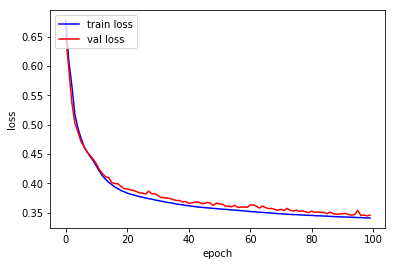

In [143]:
# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()


### 차원 축소 결과

In [24]:
encoder = Model(input_img, z)

In [25]:
# 차원 축소 결과값 추출
z_train = encoder.predict(x_train, batch_size=batch_size)
z_test = encoder.predict(x_test, batch_size=batch_size)
z_test.shape

(333, 10)

## 5. 결과 저장하기

In [26]:
y_train = Y_train
y_test = Y_test

In [27]:
# 변수저장
import pickle # 파이썬 객체저장을 위한 모듈

if df == 'all':
    file_nm = './pickles/vae_all.p'
elif df == 'main':
    file_nm = './pickles/vae_main.p'
elif df == 'core':
    file_nm = './pickles/vae_core.p'
   
    
    
# 파이썬 객체 상태로 저장하기
with open(file_nm, 'wb') as file:  # hello.txt 파일을 바이너리 쓰기 모드(wb)
    pickle.dump(z_train, file)
    pickle.dump(z_test, file)
    pickle.dump(x_train, file)   # 0~1 스케일된 데이터 유의!
    pickle.dump(x_test, file)    # 0~1 스케일된 데이터 유의!
    pickle.dump(y_train, file)
    pickle.dump(y_test, file)
    pickle.dump(train_set, file)
    pickle.dump(test_set, file)

## 6. 모델의 시각화

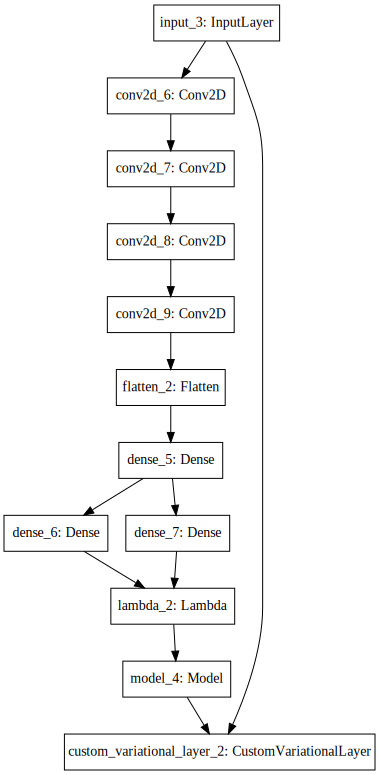

In [46]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

## 7. t-SNE로 검증하기

[참고] MNIST 데이터 세트 (비교적) 명확한 클러스터링의 시각화 - 자동 인코딩 + t-SNE dim-reduction
AE/VAE를 통해 작은 차원으로 압축한 다음 t-SNE 차원 감소를 적용하여 사람이 시각적으로 확인 가능한 작은 차원(2,3차원) 재축소시킴.

이후 그래프를 통해 시각적으로 확인가능하도록 함.

ex) 100차원의 데이터를 VAE로 10차원 압축 후, 압축된 10차원데이터를 다시 t-SNE로 2차원 압축해 의미있게 분류된 결과를 보이는지 확인

https://github.com/ncampost/vis-autoencoder-tsne

[코드출처] https://lumiamitie.github.io/r/python/tsne-for-r-py/

## 1) 파이썬 객체 가져오기! (사용 주의!)

#### VAE 모델을 돌리지 않고 과거 작업한 데이터 가져와서 사용시에만 실행!!

In [12]:
df == 'core'

True

In [13]:
if df == 'all':
    file_nm = "./pickles/vae_all.p"
elif df == 'main':
    file_nm = "./pickles/vae_main.p"
elif df == 'core':
    file_nm = "./pickles/vae_core.p"

#파이썬 객체 읽어오기
with open(file_nm, 'rb') as file:  
    z_train = pickle.load(file)
    z_test = pickle.load(file)
    y_train = pickle.load(file)
    y_test = pickle.load(file)
    train_set = pickle.load(file)
    test_set = pickle.load(file)   
    

In [14]:
z_train.shape

(755, 10)

## 2) tSNE 코드 실행

[코드출처] https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/t_sne.py

In [63]:
import numpy as np
from sklearn.manifold import TSNE

tsne_x_train = x_train.reshape(-1,x_train.shape[2])
tsne_z_train = z_train.reshape(-1,z_train.shape[1])

# 2개의 차원으로 축소
x_transformed = TSNE(n_components=2).fit_transform(tsne_x_train)
z_transformed = TSNE(n_components=2).fit_transform(tsne_z_train)
x_transformed.shape


(755, 2)

### 그래프 해석
비지도 학습을 통해 분류된 데이터에 라벨을 붙혀 유의하게 분리되어 있음을 확인

### x_train 데이터 그래프

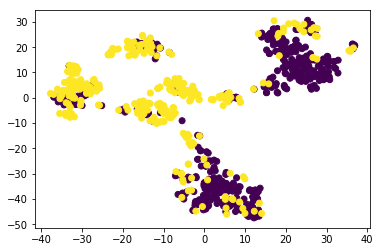

In [67]:
xs = x_transformed[:,0]
ys = x_transformed[:,1]
plt.scatter(xs,ys, c=y_train)  # 라벨은 색상으로 분류됨

plt.show()


### z_train 데이터 그래프

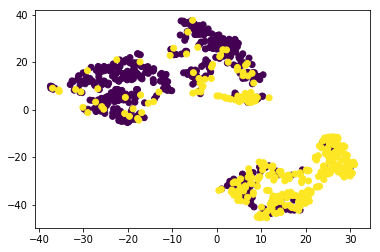

In [68]:
xs = z_transformed[:,0]
ys = z_transformed[:,1]
plt.scatter(xs,ys, c=y_train)  # 라벨은 색상으로 분류됨

plt.show()